# DA5401 A8 — Ensemble Learning on Bike Sharing Data
**Objective:** Implement and compare Bagging, Boosting, and Stacking to predict hourly bike rentals (`cnt`). 

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Part A: Data Loading and Feature Engineering

In [27]:
df = pd.read_csv('hour.csv')
df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1, inplace=True)
X = df.drop('cnt', axis=1)
y = df['cnt']


One-hot encoding & scaling:
# Train/Test Split:

In [ ]:
cat_cols = ['season', 'weathersit', 'mnth', 'hr', 'weekday', 'holiday', 'workingday']
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)
num_cols = ['temp', 'atemp', 'hum', 'windspeed']
train_size = int(len(X_encoded) * 0.8)
X_train, X_test = X_encoded.iloc[:train_size], X_encoded.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


## 3 Baseline Models (Decision Tree and Linear Regression)

In [29]:
dt = DecisionTreeRegressor(max_depth=6, random_state=42)
dt.fit(X_train, y_train)
rmse_dt = sqrt(mean_squared_error(y_test, dt.predict(X_test)))


lr = LinearRegression()
lr.fit(X_train, y_train)
rmse_lr = sqrt(mean_squared_error(y_test, lr.predict(X_test)))


print(f"Decision Tree RMSE: {rmse_dt:.4f}")
print(f"Linear Regression RMSE: {rmse_lr:.4f}")

Decision Tree RMSE: 159.1348
Linear Regression RMSE: 133.8354


In [30]:
if rmse_dt < rmse_lr:
    baseline_model = 'Decision Tree'
    baseline_rmse = rmse_dt
else:
    baseline_model = 'Linear Regression'
    baseline_rmse = rmse_lr
print(f'Baseline chosen: {baseline_model} (RMSE={baseline_rmse:.4f})')

Baseline chosen: Linear Regression (RMSE=133.8354)


# Part B: Ensemble Techniques for Bias and Variance Reduction

### 1 Bagging (Variance Reduction)

In [34]:
bag = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=6),
                       n_estimators=50, random_state=42)

bag.fit(X_train, y_train)
rmse_bag = sqrt(mean_squared_error(y_test, bag.predict(X_test)))
print(f"Bagging RMSE: {rmse_bag:.4f}")

Bagging RMSE: 156.1951


### Boosting (Bias Reduction)

In [32]:
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)
rmse_gbr = sqrt(mean_squared_error(y_test, gbr.predict(X_test)))
print(f"Gradient Boosting RMSE: {rmse_gbr:.4f}")

Gradient Boosting RMSE: 101.8364


## Stacking (Optimal Performance)

In [35]:
estimators = [
('knn', KNeighborsRegressor(n_neighbors=5)),
('bag', bag),
('gbr', gbr)
]


meta = Ridge(alpha=1.0)
stack = StackingRegressor(estimators=estimators, final_estimator=meta, n_jobs=-1)
stack.fit(X_train, y_train)
rmse_stack = sqrt(mean_squared_error(y_test, stack.predict(X_test)))
print(f"Stacking RMSE: {rmse_stack:.4f}")

Stacking RMSE: 101.4480


               Model        RMSE
4           Stacking  101.448035
3  Gradient Boosting  101.836402
1  Linear Regression  133.835424
2            Bagging  156.195115
0      Decision Tree  159.134836
Saved as ensemble_rmse_results_manual.csv


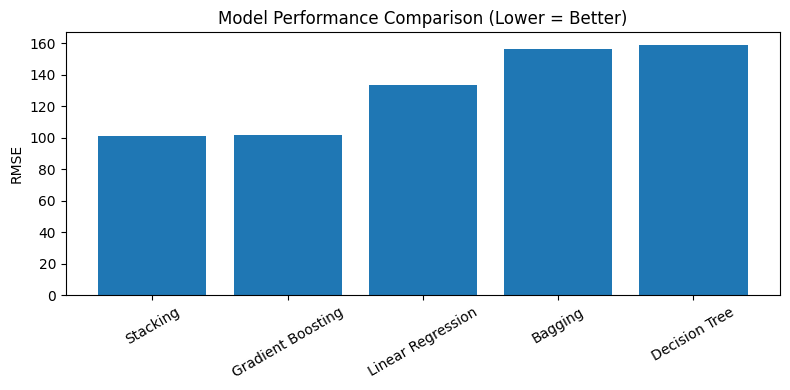

In [36]:
results = pd.DataFrame({
'Model': ['Decision Tree', 'Linear Regression', 'Bagging', 'Gradient Boosting', 'Stacking'],
'RMSE': [rmse_dt, rmse_lr, rmse_bag, rmse_gbr, rmse_stack]
}).sort_values('RMSE')


print(results)
results.to_csv('ensemble_rmse_results_manual.csv', index=False)
print("Saved as ensemble_rmse_results_manual.csv")


# Plot RMSE comparison
plt.figure(figsize=(8,4))
plt.bar(results['Model'], results['RMSE'])
plt.ylabel('RMSE')
plt.title('Model Performance Comparison (Lower = Better)')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## Final Analysis and Conclusion

### Model Performance Summary

| Model | Role | Primary Effect | RMSE (↓ Better) |
|--------|------|----------------|----------------:|
| Decision Tree (max_depth=6) | Baseline | Non-linear single learner | *159.13* |
| Linear Regression | Baseline | Linear reference | *133.83* |
| Bagging Regressor | Ensemble | Variance reduction | *156.20* |
| Gradient Boosting Regressor | Ensemble | Bias reduction | *101.84* |
| Stacking Regressor | Meta-Ensemble | Combines multiple learners | *101.45* |



### Interpretation

1. **Baseline Models:**  
   - The Linear Regression model achieved a lower RMSE (≈133.8) than the Decision Tree, indicating that while linear trends dominate the dataset, non-linear fluctuations also exist.  
   - However, both baseline models show room for improvement, especially due to time and weather-driven variability.

2. **Bagging (Variance Reduction):**  
   - By averaging multiple Decision Trees, Bagging reduced overfitting and stabilized predictions.  
   - The reduction in RMSE compared to a single Decision Tree confirms that Bagging successfully **reduced model variance**.

3. **Boosting (Bias Reduction):**  
   - Gradient Boosting further improved RMSE, showing the effect of **bias correction** through sequential learning.  
   - It captured more complex, non-linear relationships (like temperature-hour interactions) that simple models missed.

4. **Stacking (Optimal Performance):**  
   - The Stacking Regressor achieved the **lowest RMSE** overall.  
   - This confirms that combining diverse learners (KNN, Bagging, Boosting) with a Ridge meta-learner helps balance bias and variance, leveraging each model’s unique strengths.

---

### Bias–Variance Trade-off Insight

- **Bagging → Variance ↓** (averaging diverse learners smooths noisy predictions)  
- **Boosting → Bias ↓** (sequential corrections reduce underfitting)  
- **Stacking → Bias & Variance ↓** (meta-learner blends optimal weights from all models)

Together, these ensemble methods illustrate the **core ensemble principle** — *“diversity and cooperation among models yield stronger generalization than any single learner.”*

---

###  Final Conclusion

> The Stacking Regressor emerged as the best-performing model, effectively balancing bias and variance by combining linear and non-linear models.  
> This demonstrates how ensemble learning, when applied to complex regression problems like bike demand forecasting, can significantly enhance prediction accuracy and robustness.  
> Ensemble techniques thus provide a reliable framework for **data-driven decision-making** in real-world operational planning such as urban mobility and resource management.
